# A look at the distribution of development effort for various Scientific Python projects from Git logs

A quick look at some data related to the development of widely used projects in the Scipy ecosystem.  This notebook consists of two parts, first the collection of data from github into csv files and second some plots made from these files.  It's a good idea to do a manual pass over the csv files to unify committers who may appear under multiple names if the project doesn't have a good and up to date .mailmap file.

These results were presented for the first time as part of my keynote at EuroSciPy 2011 in Paris, but I've received recently queries about it several times, so I figured I'd clean up the code and put it up permanently somewhere.  Having it as a notebook example works pretty well, and once our conversion machinery works a bit better, I'll just export it into a blog post.  For now putting it on github is as good as any.

*Note:* while the title above talks about SciPy projects, this is really just a look at the distribution of committers in any grup of projects for which you have git repositories.  You can run this notebook against any group of git repos you want, there's nothing SciPy specific in the actual log analysis.


Fernando Perez - 2012.

## Collect statistics on the git repositories

Start by configuring here which projects you want to run over and where they are located on your disk, as well as the date from which to start analyzing statistics.

If you don't have them already, you can clone the default list of them in one shot using [pyston](https://github.com/fperez/pyston) with the command `pyston clone all`.

In [1]:
# Date range for the analysis, leave either as None to cover full history
start_date = '2009-06'
end_date = None

# where to store CSV stats
output_dir = 'git-stats'

# Projects for which you have a git repo
projects = ['ipython', 'numpy', 'scipy', 'matplotlib', 'sympy', 
            'cython', 'statsmodels', 'scikit-learn', 'scikits-image',
            'pandas', 'PyTables', 'networkx', 'mayavi']

# Base location of your git repos above
repo_base = '/home/fperez/tmp/src/scipy/'

from os.path import join
repos = [join(repo_base, p) for p in projects ]

We define a function to collect the stats from a git repo and one to convert that into a CSV file that we can conveniently load afterwards

In [5]:
import subprocess as sp
import tempfile
import os


def git_stats(repo, start_date=None, end_date=None):
    """Compute git shortlog stats since a given date.

    Return a list of pairs of committer, number of commits.
    """
    since = '' if start_date is None else '--since=%s' % start_date
    until = '' if end_date is None else '--until=%s' % end_date
    
    # This is the sensible way to do this, but it may fail...
    output = sp.Popen(['git', 'shortlog', '-sn', since, until], 
                      stdout=sp.PIPE, cwd=repo).communicate()[0]
    
    # This looks a bit absurd, but when running in IPython over zmq (i.e. in the 
    # notebook or qtconsole), *any* form of calling 'git shortlog' produces no
    # output.  In that case, we can use a quirky workaround, that involves using
    # IPython's own system call (that uses pexpect), saving to a temporary file
    # git's output and reading it back.  I think it's a bug in git that shortlog
    # does the wrong thing when not on a tty: `git log` is fine, the problem is specific
    # to the shortlog subcommand, so I'm pretty sure it's a git bug.
    if not output:
        tfile = tempfile.mktemp()
        ip = get_ipython()
        ip.system('cd "%s" && (git shortlog -sn %s %s > %s)' % 
                                    (repo, since, until, tfile))
        output = open(tfile).read()
        os.unlink(tfile)
        
    items = []
    for line in output.splitlines():
        p = line.split(None, 1)
        name = p[1].replace(',', '') # commas in the first field will mess up csv loading
        items.append((name, p[0]))
    return items


def csv_stats(repo, start_date=None, end_date=None):
    """Compute git stats and write them to a csv file based on the repo name.
    """
    fname = os.path.split(repo.rstrip('/'))[1] + '.csv'
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    fname = join(output_dir, fname)
    if os.path.isfile(fname):
        print "Not writing file %s, already exists" % fname
        return
    
    stats = git_stats(repo, start_date, end_date)

    with open(fname, 'w') as f:
        f.write('# Git commit stats for date range: %s..%s\n' % (start_date, end_date))
        for s in stats:
            f.write('%s, %s\n' % s)
        print "File written:", f.name, ':', len(stats), 'lines.'

This is the step that actually creates the CSV files.  Note: it will **not** overwrite existing files to protect manual cleanups you may have done.

In [6]:
!rm -f $output_dir/*.csv  # in case you want to nuke and redo
[csv_stats(r, start_date, end_date) for r in repos];

File written: git-stats/ipython.csv : 126 lines.
File written: git-stats/numpy.csv : 78 lines.
File written: git-stats/scipy.csv : 51 lines.
File written: git-stats/matplotlib.csv : 62 lines.
File written: git-stats/sympy.csv : 116 lines.
File written: git-stats/cython.csv : 41 lines.
File written: git-stats/statsmodels.csv : 16 lines.
File written: git-stats/scikit-learn.csv : 78 lines.
File written: git-stats/scikits-image.csv : 30 lines.
File written: git-stats/pandas.csv : 30 lines.
File written: git-stats/PyTables.csv : 8 lines.
File written: git-stats/networkx.csv : 11 lines.
File written: git-stats/mayavi.csv : 27 lines.


## Plot results

Now we read from disk the (possibly manually fine-tuned) csv files and make some plots

In [13]:
import os
from glob import glob
from matplotlib import mlab

all_csv = set([join(output_dir, p) + '.csv' for p in projects])
csv_files = sorted(glob(join(output_dir, '*.csv')))
missing = all_csv - set(csv_files)
if missing:
    print 'Projects configured but with no CSV file:', sorted(missing)
print 'Files to analyze:\n', csv_files

Files to analyze:
['git-stats/PyTables.csv', 'git-stats/cython.csv', 'git-stats/ipython.csv', 'git-stats/matplotlib.csv', 'git-stats/mayavi.csv', 'git-stats/networkx.csv', 'git-stats/numpy.csv', 'git-stats/pandas.csv', 'git-stats/scikit-learn.csv', 'git-stats/scikits-image.csv', 'git-stats/scipy.csv', 'git-stats/statsmodels.csv', 'git-stats/sympy.csv']


In [14]:
def repo_viz(csv_file, xmax=None, norm=None, ax=None, linestyle=None, marker=None):
    """Visualize commit data for a repository.
    """
    if ax is None:
        ax = plt.gca()
    try:
        arr = loadtxt(csv_file, usecols=[1], delimiter=',')
    except:
        print 'Error converting file', csv_file, 'to array with loadtxt.'
        return
    # Now, normalize if required
    if norm == 'first':
        arr /= arr[0]
    elif norm == 'sum':
        arr /= arr.sum()
        
    fname = os.path.split(csv_file.rstrip('/'))[1]
    repo = os.path.splitext(fname)[0]
    
    linestyle = '-' if linestyle is None else linestyle
    marker = 'o' if marker is None else marker
    ax.plot(arange(1, len(arr)+1), arr, lw=1, label=repo, linestyle=linestyle, marker=marker)
    ax.set_xlabel('Individual Committer')
    ax.legend()
    ax.set_xlim(left=1)
    if norm == 'first' or norm == 'sum':
        ax.axhline(0.2, lw=1, color='k', linestyle='--')
        ax.set_ylabel('Commit rate')
    else:
        ax.set_ylabel('# of commits')
    if xmax is not None:
        ax.set_xlim(right=xmax)

Now let's make the figures.  We make a file spec that cycles line styles and markers so we can distinguish these many lines in a single plot.

In [15]:
import itertools as it
linestyles = ['-', '--', '-.']
markers = ['D', 'h', 'o', 'p', 's', 'v', '<', '>', '*']
spec = zip(csv_files, it.cycle(linestyles), it.cycle(markers))

First a plot with the raw commit rates.  This is useful but slightly harder to interpret than a normalized one:

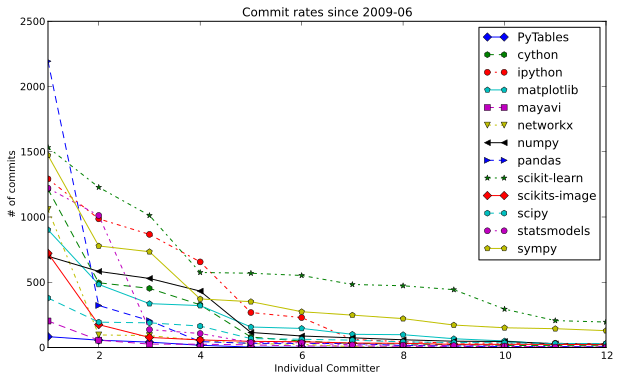

In [16]:
fig2, ax2 = plt.subplots(figsize=(10,6))
[repo_viz(f, xmax=12, ax=ax2, linestyle=ls, marker=m) for f, ls, m in spec ]
ax2.set_title('Commit rates since %s' % start_date);

It is more informative to look at *normalized* commit rates, where in this case we've scaled everything by the most prolific committer, so that we see relative rates.  A line at 20% is drawn for reference, as an (arbitrary) cutoff to count the number of 'very active' committers in each project.

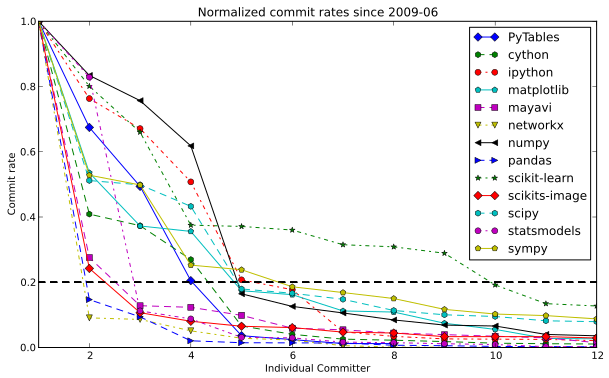

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
[repo_viz(f, xmax=12, norm='first', ax=ax, linestyle=ls, marker=m) for  f, ls, m in spec ]
ax.set_title('Normalized commit rates since %s' % start_date);

We see immediately strong differences between the various projects: while scikit-learn and sympy have a healthy spread of activity amongst a large team, at the other extreme we see NetworkX and Pandas with highly concentrated curves that indicate the vast majority of the effort lies in the hands of just one or two people.  Sklearn shows an impressively good plot, with the load spread around a large team, a testament to the work the team has done in making the project welcoming to newcomers.  Their documentation, active list and clear guidelines for contribution, as well as a well organized internal codebase, are paying off big time in helping new members become active.

IPython isn't in terrible shape, in that at least we see its curve stays up for a bit, but after ~6 committers it does go down.  We've had some great new participants in the project and also more activity from a broader base in the last few years, but I still worry that the load is too concentrated.  I do remain optimistic that all the new work we've been doing in refactoring the internals is helping make IPython more accessible, and we do see more activity from new contributors in the list and on github.  With a bit of luck, in a couple of years our curve will also be less sharply peaked...

If we look a the files for NetworkX and Pandas, we can see a bit what's going on in more detail:

In [18]:
!head $output_dir/networkx.csv
print
!head $output_dir/pandas.csv

# Git commit stats for date range: 2009-06..None
Aric Hagberg, 1058
Dan Schult, 96
Chris Ellison, 91
Loïc Séguin-C., 54
Ben Edwards, 30
loicseguin, 24
Jesus Cerquides, 6
Fernando Perez, 1
convert-repo, 1

# Git commit stats for date range: 2009-06..None
Wes McKinney, 2194
Adam Klein, 322
Chang She, 206
Thomas Kluyver, 45
Dieter Vandenbussche, 32
Wouter Overmeire, 31
Skipper Seabold, 30
Yaroslav Halchenko, 15
Luca Beltrame, 12


It's clear that both NetworkX and Pandas currently have a very small team, despite being both extremely useful and important projects.  They have clean codebases with great documentation and both cover very interesting topics, so if you are looking to contribute to the Scientific Python ecosystem, consider helping out these projects!  (Obviously help is always welcome on all projects, but I think it's worth finding which ones are right now in most need of more shoulders to bear the load).

Actually regarding NetworkX, it's possible the above stats are slightly skewed by their development process.  I did my analysis off the [NetworkX Github repository](https://github.com/networkx/networkx), but as I was working I realized NX didn't have a proper mailmap file and submitted [a pull request correcting this](https://github.com/networkx/networkx/pull/9).  Aric promptly integrated it, but he did so via a patch he applied directly on their [upstream mercurial repo](http://networkx.lanl.gov/hg/networkx/rev/24dc63984b6c).  So it's possible that due to this development process, many contributions counted for Aric in the stats above actually come from a larger pool of authors, and that the situation isn't as worrisome as I first thought.  But it still means Aric is in charge of the bulk of the merge work...